# Analyzing velocity and pumping with Pharaglow

## Importing packages

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np

# plotting
import matplotlib  as mpl
import matplotlib.pylab as plt

# image processing
import skimage
from skimage import io
from skimage.util import img_as_float
from skimage.filters import threshold_li
from scipy import ndimage
from skimage.morphology import remove_small_objects
from skimage.exposure import histogram
import json
import pims
import trackpy as tp

# our packages
from pharaglow import extract, util
from pharaglow.util import smooth

## Directing path options and variables (CHANGE NAMES OR YOUR FILES ARE OVERWRITTEN)

In [2]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/test"
INF100 = "/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_INF100/"

# IS THERE A LAWN?
lawn = 'Yes' #or 'No'
print('Is there a lawn?', lawn)

# FPS?
fps = 30
print('fps:', fps)

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# FIGURE NAMES
# all_velocities = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_all_velocities.pdf"
# averaged_velocities = "/home/nzjacic/Desktop/Rough_figures/10x_INF100/10x_INF100.5_combined_averaged_velocities.pdf"
# entry_trajectory = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_entries_trajectories.pdf"

Is there a lawn? Yes
fps: 30


## Defining functions

### Defining function to prepare binary of lawn image

In [3]:
def prepLawn(filename):
    # outlining lawn and turning into binary - thresholding with li (CHANGE NAME)
    image = img_as_float(skimage.io.imread(filename)).astype(np.float64)
    thresh = threshold_li(image)
    binary = image > thresh
    # troubleshooting images with noise around the lawn (optional)
    binary = remove_small_objects(binary, min_size = 5000, connectivity = 2) #change min_size 
    # filling small holes in the lawn
    binary = ndimage.binary_fill_holes(binary).astype(int)
    return binary

### Defining functions to extract velocity, pumping and kymo (?)

In [4]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(traj):
    return extract.bestMatchPeaks(traj['pumps'])

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

### Defining how Python reads in Pharaglow and lawn data

In [5]:
%%time
def readData(dataFolder, umPerPx, fps, j = 0):
    df = {}
    lawnImages = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            p, pump, pks, roc  = getPumps(traj)
            kymo = getKymo(traj, 'Straightened')
            df[j] = {'time': t,
                     'x': traj['x'],
                     'y': traj['y'],
                             'velocity':v,
                             'peaks': p,
                             'pumpTrace':pump.values,
                             'inside': traj['inside'],
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo
                                 }
            j +=1
            # creating dictionary of lawn images based on exp.ID if necessary
#             if lawn == 'Yes':
#                 lawnfile = particle_index
#                 if lawnfile not in lawnImages.keys():
#                     lawnpath = '/media/scholz_la/hd2/Nicolina/Lawns/'
#                     lawnImages[lawnfile] = prepLawn(os.path.join(lawnpath, lawnfile+'_lawn.tiff') or os.path.join(lawnpath, lawnfile+'_lawn.bmp'))
#                     print(lawnfile)
    return df

CPU times: user 0 ns, sys: 8 µs, total: 8 µs
Wall time: 13.6 µs


## Plotting

### Reading in Pharaglow results for different strains/conditions

In [6]:
%%time

# Making dictionary combining data with strain name in their separate master folders
Data = {}
for strainName, folder in zip(['Control', 'INF100'], [ctrl, INF100]):
    Data[strainName] = readData(folder, umPerPx, fps)

# # control
# ctrlData = ctrlData.update(readData(folder, umPerPx, fps, j = j))

# # strain 1 - INF100
# INF100Data ={}
# j = 0
# for folder in INF100:
#     INF100Data.update(readData(folder, umPerPx, fps, j = j))
#     j = max(INF100Data.keys())+1

Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_8.json


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  # Remove the CWD from sys.path while we load stuff.


Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_0.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_1.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_10.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_11.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_12.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_13.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_14.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047

### Extract velocity and pumping for all conditions

Beginning analysis...
velocity pid: Control 0
f: 0.42
t0: 1132
Pumping checkpoint
pumping pid: Control 0
velocity pid: Control 1
f: 0.7354150461162351
t0: 1378
Pumping checkpoint
pumping pid: Control 1
velocity pid: Control 2
f: 0.5116904058048911
t0: 1173
Pumping checkpoint
pumping pid: Control 2
pid Control 3
f out of bounds
velocity pid: Control 4
f: 0.6356925749023014
t0: 645
trajectory is too short
velocity pid: Control 5
f: 0.7688723205964585
t0: 0
trajectory is too short
velocity pid: Control 6
f: 0.5004760393525864
t0: 91
trajectory is too short
velocity pid: Control 7
f: 0.22931541369172617
t0: 1835
Pumping checkpoint
pumping pid: Control 7
pid Control 8
f out of bounds
pid Control 9
f out of bounds
pid Control 10
f out of bounds
pid Control 11
f out of bounds
velocity pid: Control 12
f: 0.67896432936993
t0: 783
trajectory is too short
pid Control 13
f out of bounds
velocity pid: Control 14
f: 0.7029702970297029
t0: 0
trajectory is too short
velocity pid: Control 15
f: 0.79553

Text(0.5, 1.0, 'Pumping Rate (Hz) of Trajectories per Video')

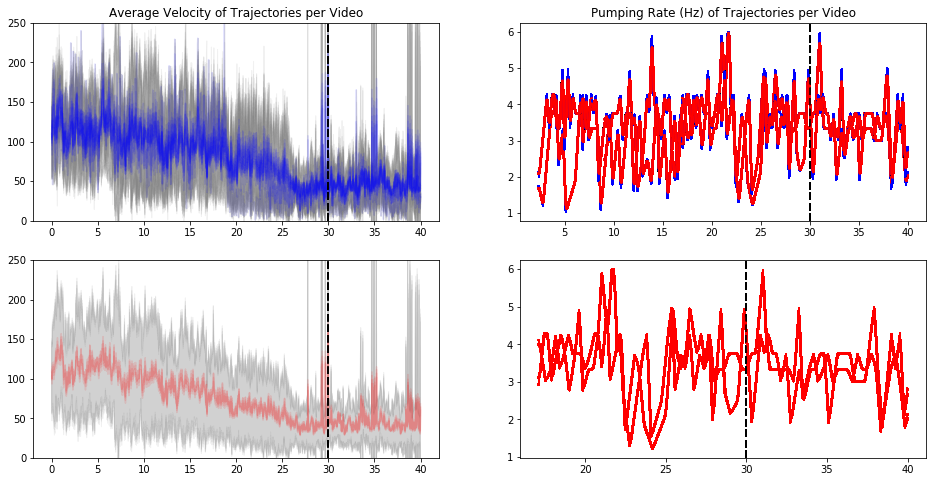

In [204]:
# color dictionary
colors = {
    'INF100':'red',
    'Control':'blue'
}
# assigning time before entry (dt) and time after entry (da)
dt = 900
da = 300
# change number of rows to the number of strains
f1 = plt.figure(figsize = (16,8))
grid = mpl.gridspec.GridSpec(ncols=2, nrows =2)
# setting up subplots for velocity (a) and pumping (b) - add as number of strains increase
# velocity
ax1a = f1.add_subplot(grid[0,0])
ax2a = f1.add_subplot(grid[1,0])
axa = [ax1a, ax2a]
# pumping
ax1b = f1.add_subplot(grid[0,1])
ax2b = f1.add_subplot(grid[1,1])
axb = [ax1b, ax2b]

# lists needed for plotting
cutVelocities = []
pil = []
pumpingrates = []

# plotting velocity and pumping
if lawn is 'Yes':
    print('Beginning analysis...')
    for ci, condition in enumerate(Data.keys()):
        for idx in Data[condition].keys():
            f = (Data[condition][idx]['inside']).mean()
            print('velocity pid:', condition, idx)
            if f<0.9 and f>0.01:
                print('f:', f)
                t0 = np.where(Data[condition][idx]['inside'] ==1)[0][0]
                try:
                    if t0>dt:
                        print('t0:', t0)
                        # velocity plotting
                        time = np.linspace(0, (dt+da)/fps, dt+da)
                        cutVelocities.append(Data[condition][idx]['velocity'][t0-dt:t0+da])
                        mv, sv = np.mean(np.array(cutVelocities), axis =0), np.std(np.array(cutVelocities), axis =0)
                        axa[ci].plot(time, mv, color = colors[condition], alpha = 0.1)
                        axa[ci].fill_between(np.arange(len(mv))/fps, mv-sv, mv+sv, 
                                             color = 'gray', alpha = 0.1)
                        axa[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
                        # pumping plotting
                        print('Pumping checkpoint')
                        print('pumping pid:', condition, idx)
                        for i in Data[condition][idx]['peaks'].keys():
                            pi = Data[condition][idx]['peaks']
                            pi = pi.values/fps
                            pil.append(pi)
                            pumpingrate = fps/np.diff(Data[condition][idx]['peaks'])
                            pumpingrates.append(pumpingrate)
                            pumpNew = np.interp(time, pil[i][:-1], np.array(pumpingrates)[i], left = 0, right = 0)
                            axb[ci].plot(time[t0-dt:t0+da], pumpNew[t0-dt:t0+da], color = colors[condition], alpha = 0.2)
                            axb[ci].plot(time[t0-dt:t0+da], smooth(pumpNew[t0-dt:t0+da], 10), 'r', lw =2)
                            axb[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
                    else:
                        print('trajectory is too short')
                        continue
                except ValueError:
                    print('t0-dt or t0+dt exceeds number of frames')
                    continue
            else:
                print('pid', condition, idx)
                print('f out of bounds')
                continue
        print (condition, idx, 'complete')
# making things pretty
ax1a.set_ylim(0,250)
ax1a.set_title('Average Velocity of Trajectories per Video')
ax2a.set_ylim(0,250)
ax1b.set_title('Pumping Rate (Hz) of Trajectories per Video')

#### Messy code

Beginning analysis...
velocity pid: Control 0
f: 0.42
t0: 1132
Pumping checkpoint
pumping pid: Control 0
velocity pid: Control 1
f: 0.7354150461162351
t0: 1378
Pumping checkpoint
pumping pid: Control 1
velocity pid: Control 2
f: 0.5116904058048911
t0: 1173
Pumping checkpoint
pumping pid: Control 2
pid Control 3
f out of bounds
velocity pid: Control 4
f: 0.6356925749023014
t0: 645
trajectory is too short
trajectory is too short
velocity pid: Control 5
f: 0.7688723205964585
t0: 0
trajectory is too short
trajectory is too short
velocity pid: Control 6
f: 0.5004760393525864
t0: 91
trajectory is too short
trajectory is too short
velocity pid: Control 7
f: 0.22931541369172617
t0: 1835
Pumping checkpoint
pumping pid: Control 7
pid Control 8
f out of bounds
pid Control 9
f out of bounds
pid Control 10
f out of bounds
pid Control 11
f out of bounds
velocity pid: Control 12
f: 0.67896432936993
t0: 783
trajectory is too short
trajectory is too short
pid Control 13
f out of bounds
velocity pid: Co

Text(0.5, 1.0, 'Pumping Rate (Hz) of Trajectories per Video')

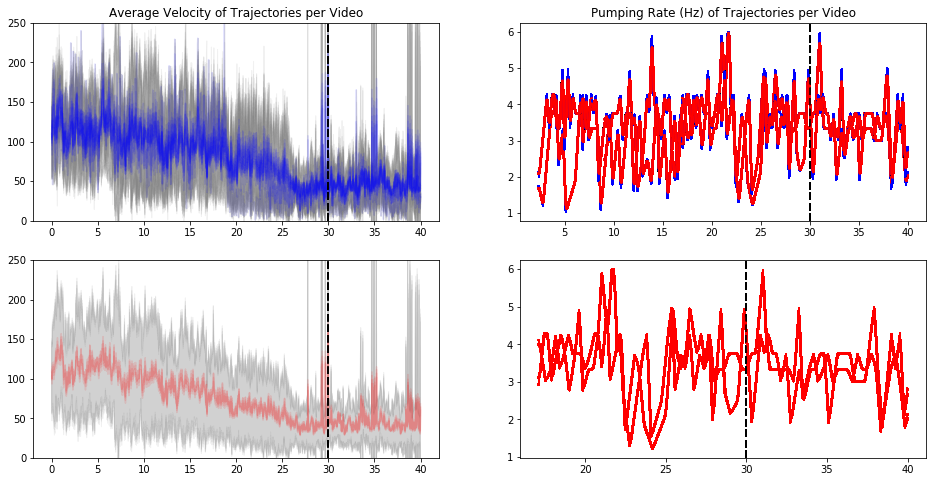

In [201]:
# # color dictionary
# colors = {
#     'INF100':'red',
#     'Control':'blue'
# }
# # assigning time before entry (dt) and time after entry (da)
# dt = 900
# da = 300
# # change number of rows to the number of strains
# f1 = plt.figure(figsize = (16,8))
# grid = mpl.gridspec.GridSpec(ncols=2, nrows =2)
# # setting up subplots for velocity (a) and pumping (b) - add as number of strains increase
# # velocity
# ax1a = f1.add_subplot(grid[0,0])
# ax2a = f1.add_subplot(grid[1,0])
# axa = [ax1a, ax2a]
# # pumping
# ax1b = f1.add_subplot(grid[0,1])
# ax2b = f1.add_subplot(grid[1,1])
# axb = [ax1b, ax2b]

# # lists needed for plotting
# cutVelocities = []
# pil = []
# pumpingrates = []
# #pumpingNew = []

# # plotting velocity and pumping - ASSIGNING INF100 TO CONTROL
# if lawn is 'Yes':
#     print('Beginning analysis...')
#     for ci, condition in enumerate(Data.keys()):
#         for idx in Data[condition].keys():
#             f = (Data[condition][idx]['inside']).mean()
#             if f<0.9 and f>0.01:
#                 print('velocity pid:', condition, idx)
#                 print('f:', f)
#                 t0 = np.where(Data[condition][idx]['inside'] ==1)[0][0]
#                 print('t0:', t0)
#                 try:
#                     if t0>dt:
#                         #time = np.linspace(0,2*dt/30., 2*dt)
#                         time = np.linspace(0, (dt+da)/fps, dt+da)
#                         cutVelocities.append(Data[condition][idx]['velocity'][t0-dt:t0+da])
#                         mv, sv = np.mean(np.array(cutVelocities), axis =0), np.std(np.array(cutVelocities), axis =0)
#                         axa[ci].plot(time, mv, color = colors[condition], alpha = 0.1)
#                         axa[ci].fill_between(np.arange(len(mv))/fps, mv-sv, mv+sv, 
#                                              color = 'gray', alpha = 0.1)
#                         axa[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
#                     else:
#                         print('trajectory is too short')
#                 except ValueError:
#                     print('t0-dt or t0+dt exceeds number of frames')
#                 try:
#                     if t0>dt:
#                         ### with pumping alignment
#                         time = np.linspace(0, (dt+da)/fps, dt+da)
#                         print('Pumping checkpoint')
#                         print('pumping pid:', condition, idx)
#                         for i in Data[condition][idx]['peaks'].keys():
#                             pi = Data[condition][idx]['peaks']
#                             pi = pi.values/fps
#                             pil.append(pi)
#                             pumpingrate = fps/np.diff(Data[condition][idx]['peaks'])
#                             pumpingrates.append(pumpingrate)
#                             pumpNew = np.interp(time, pil[i][:-1], np.array(pumpingrates)[i], left = 0, right = 0)
#                             #pumpingNew.append(pumpNew)
#                             axb[ci].plot(time[t0-dt:t0+da], pumpNew[t0-dt:t0+da], color = colors[condition], alpha = 0.2)
#                             axb[ci].plot(time[t0-dt:t0+da], smooth(pumpNew[t0-dt:t0+da], 10), 'r', lw =2)
#                             axb[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
#                     else:
#                         print('trajectory is too short')
#                 except ValueError:
#                     print('t0-dt or t0+dt exceeds number of frames')
#                     continue
#             else:
#                 print('pid', condition, idx)
#                 print('f out of bounds')
#                 continue
# ax1a.set_ylim(0,250)
# ax1a.set_title('Average Velocity of Trajectories per Video')
# ax2a.set_ylim(0,250)
# ax1b.set_title('Pumping Rate (Hz) of Trajectories per Video')